In [290]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import tensorflow as tf
import keras
from keras import layers

In [291]:
# Trying to make an improved version
df = pd.read_csv("star_classification.csv")

# Dropping columns unrelated to the class
columns_to_drop = ["obj_ID", "run_ID", "rerun_ID", "cam_col", "field_ID", "spec_obj_ID", "plate", "MJD", "fiber_ID"]
df = df.drop(columns_to_drop, axis=1)

print(df["class"].value_counts())
# This time I am balancing the three star classes so they are equally represented
grouped = df.groupby('class')
class_samples = []

for group, data in grouped:
    sample = data.sample(n=1000)
    class_samples.append(sample)

balanced_df = pd.concat(class_samples)

class
GALAXY    59445
STAR      21594
QSO       18961
Name: count, dtype: int64


In [292]:
df = balanced_df
print(df["class"].value_counts())
# Pairplot can give an idea about the important variables for predicting the class
# Especially useful are features that make it easy to separate clusters of the classes
#sns.pairplot(data=df.sample(n=100), hue="class")

class
GALAXY    1000
QSO       1000
STAR      1000
Name: count, dtype: int64


In [293]:
# everything else except the target variable
X = df.drop("class", axis=1)

# have only the target variable here (dependent variable)
y = df['class']

# Normalization
#X_mm = MinMaxScaler().fit_transform(X)
X_mm = StandardScaler().fit_transform(X)

# since we are doing classification, we have to process our target values with an encoder
# and convert them into a categorical TensorFlow/Keras -format 
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Converting the label into a matrix form
y = tf.keras.utils.to_categorical(y_enc)

In [294]:
# convert all continuous variables to integer,
# and convert all negative numbers to 0
X_cat = X.astype(int)
X_cat = X_cat.clip(lower=0)

# initialize chi2 and SelectKBest
# Note: chi2 -test is a very common test
# in statistics and quantitative analysis
# basically it studies the data whether variables are related
# or independent of each other
chi_2_features = SelectKBest(chi2, k=len(X_cat.columns))

# fit our data to the SelectKBest
best_features = chi_2_features.fit(X_cat,y.astype(int))

# use decimal format in table print later
pd.options.display.float_format = '{:.2f}'.format

# wrap it up, and show the results
# the higher the score, the more effect that column has on price
df_features = pd.DataFrame(best_features.scores_)
df_columns = pd.DataFrame(X_cat.columns)
f_scores = pd.concat([df_columns,df_features],axis=1)
f_scores.columns = ['Features','Score']
f_scores.sort_values(by='Score',ascending=False)

,Features,Score
7,redshift,2471.51
0,alpha,1009.42
1,delta,286.00
6,z,131.71
5,i,111.75
4,r,74.46
3,g,54.85
2,u,48.18


In [295]:
# Train/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.20)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

# Creating list of the categories
categories = list(np.unique(df['class']))

In [296]:
# Hopefully better neural network for classification
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(len(X.columns),)),
        layers.Dense(16, activation="relu", input_shape=(len(X.columns),)),
        layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l1(l=0.1)),
        layers.Dense(16, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(len(categories), activation="softmax")
    ]
)

# Set a custom learning rate
optimizer = keras.optimizers.Adam(lr=0.001)

# Model compilation and some info about the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_22 (Ba  (None, 8)                 32        
 tchNormalization)                                               
                                                                 
 dense_164 (Dense)           (None, 16)                144       
                                                                 
 dense_165 (Dense)           (None, 64)                1088      
                                                                 
 dense_166 (Dense)           (None, 16)                1040      
                                                                 
 dense_167 (Dense)           (None, 64)                1088      
                                                                 
 dense_168 (Dense)           (None, 32)                2080      
                                                     

In [297]:
# Epochs can be adjusted
model.fit(x=X_train, y=y_train, epochs=200, validation_data=(X_val, y_val))

Epoch 1/200


75/75 [==============================] - 2s 5ms/step - loss: 11.5252 - accuracy: 0.5021 - val_loss: 8.4052 - val_accuracy: 0.5767
Epoch 2/200
75/75 [==============================] - 0s 2ms/step - loss: 5.6322 - accuracy: 0.7408 - val_loss: 3.4895 - val_accuracy: 0.7533
Epoch 3/200
75/75 [==============================] - 0s 2ms/step - loss: 2.2465 - accuracy: 0.7933 - val_loss: 1.3958 - val_accuracy: 0.7767
Epoch 4/200
75/75 [==============================] - 0s 2ms/step - loss: 0.9710 - accuracy: 0.8083 - val_loss: 0.7027 - val_accuracy: 0.8433
Epoch 5/200
75/75 [==============================] - 0s 2ms/step - loss: 0.6689 - accuracy: 0.8342 - val_loss: 0.5221 - val_accuracy: 0.8800
Epoch 6/200
75/75 [==============================] - 0s 2ms/step - loss: 0.5765 - accuracy: 0.8562 - val_loss: 0.5264 - val_accuracy: 0.8700
Epoch 7/200
75/75 [==============================] - 0s 2ms/step - loss: 0.5407 - accuracy: 0.8596 - val_loss: 0.4713 - val_accuracy: 0.8800
Epoch 8/200
75/75 [=====

<Axes: >

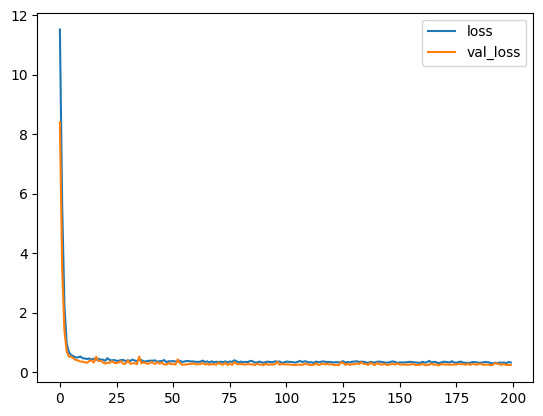

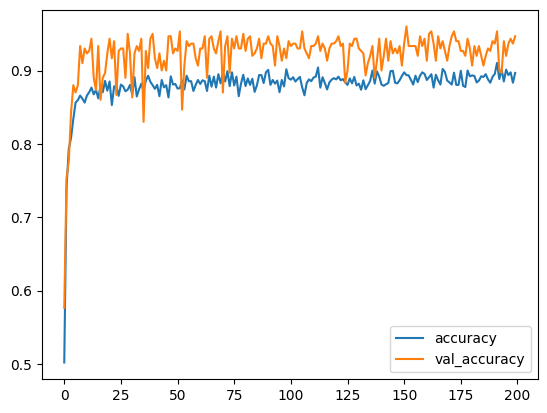

In [298]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()
loss_df[['accuracy', 'val_accuracy']].plot()

In [299]:
# compare the final model loss/accuracy/evaluation values
# the values should again match mostly
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

# get predictions and convert with argmax() to get categories 
# instead of raw probabilities
test_predictions = model.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)

# convert also y-test -values with argmax
y_test = np.argmax(y_test, axis=1)

Test data evaluation:
[0.2601996660232544, 0.9366666674613953]

Train data evaluation:
[0.2623515725135803, 0.9308333396911621]
10/10 [==============================] - 0s 1ms/step


<Axes: >

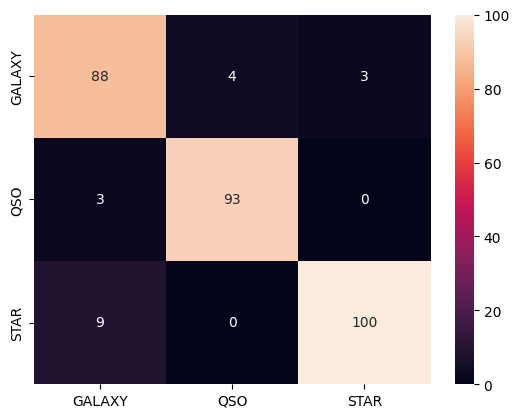

In [300]:
# Heatmap with category names
sns.heatmap(confusion_matrix(y_test, test_predictions), xticklabels=categories, yticklabels=categories, annot=True, fmt='g')

In [301]:
# print the classification report based on true values and predictions
print(classification_report(y_test, test_predictions, target_names=categories))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

# Computing the ROC-AUC -score
print(roc_auc_score(y, model.predict(X), multi_class="ovr"))

              precision    recall  f1-score   support

      GALAXY       0.88      0.93      0.90        95
         QSO       0.96      0.97      0.96        96
        STAR       0.97      0.92      0.94       109

    accuracy                           0.94       300
   macro avg       0.94      0.94      0.94       300
weighted avg       0.94      0.94      0.94       300


Model overall accuracy: 93.67%
94/94 [==============================] - 0s 1ms/step
0.9862151666666664


In [302]:
# Make a new test prediction

test_row = {
    'alpha': 140, 
    'delta': 35, 
    'u': 25, 
    'g': 23, 
    'r': 20, 
    'i': 20, 
    'z': 19,
    'redshift': 4
}

# convert to pandas-format
tester_row = pd.DataFrame([test_row])
result = model.predict(tester_row)[0]
print(result.round(3))

result_index = np.argmax(result)
print(result_index)

# print the actual name with this index
result_text = categories[result_index]

# print the result
print(f"Predicted price range: {result_text}")

1/1 [==============================] - 0s 128ms/step
[0. 1. 0.]
1
Predicted price range: QSO
